Now we demonstrate how to use the online learning version of the fixed-point ensemble

In [1]:
%matplotlib inline
import pylab
import numpy as np
import nengo                    # this can be installed with "pip install nengo --user"
import fixed_ensemble_learning  # this is just a file in this directory

We use exactly the same setup as in the offline learning version

In [2]:
n_neurons = 100  # number of neurons in the ensemble

n_inputs = 1     # the dimensionality of the input.  If you change this, you must
                 #  change train_signal (below) to have that dimensionality
    
n_outputs = 2    # the dimensionality of the output.  If you change this, you must
                 #  make sure the desired_function outputs that same dimensionality
    
desired_function = lambda x: (x[0]**2, -x[0])  # the function to approximate with the neurons

seed = 1      # random number seed used to generate neuron properties

ens = fixed_ensemble_learning.FixedEnsembleLearning(n_inputs=n_inputs, 
                                                    n_outputs=n_outputs,
                                                    n_neurons=n_neurons,
                                                    decoder_bits=12,
                                                    seed=seed)



Now we provide a training signal along with an error signal, which indicates how wrong the model was on the previous time-step.  The network will use this to adjust its own decoders.  We start with all-zero decoders, so we expect this error to be large initially, and then gradually decrease.

In [3]:
# number of time steps to train for
train_time = 10000

train_t = np.arange(train_time)

# the signal provided for training
train_signal = np.sin(train_t * 2 * np.pi / 1000)
train_signal.shape = train_time, n_inputs

target = np.array([desired_function(x) for x in train_signal])


error = np.zeros(n_outputs)
decoded = np.zeros((train_time, n_outputs))
for i in range(train_time):
    value = ens.step(train_signal[i]*ens.input_max, error*ens.input_max)/float(ens.input_max)
    decoded[i] = value
    
    error = value - target[i]


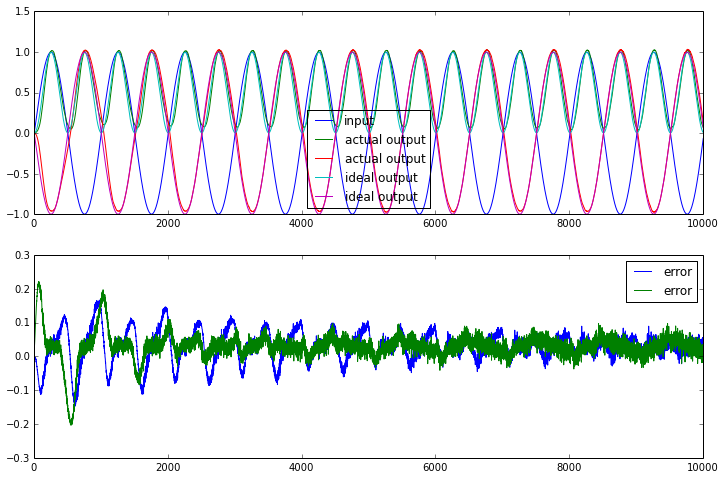

In [4]:
filter = nengo.synapses.Lowpass(10)
error = decoded - filter.filt(target, dt=1)

pylab.figure(figsize=(12,8))
pylab.subplot(2, 1, 1)
pylab.plot(train_t, filter.filt(train_signal, dt=1), label='input')
pylab.plot(train_t, filter.filt(decoded, dt=1), label='actual output')
pylab.plot(train_t, filter.filt(target, dt=1), label='ideal output', lw=1)
pylab.legend(loc='best')
pylab.subplot(2, 1, 2)
pylab.plot(train_t, error, label='error')
pylab.legend(loc='best')
pylab.show()

Now we test this by running it as before, but providing zero for the error.

In [5]:
test_time = 8000
output = np.zeros((test_time, n_outputs))

test_t = np.arange(test_time)

rng = np.random.RandomState(seed=1)
test_signal = nengo.processes.WhiteSignal(period=4, high=2).run(test_time*0.001, dt=0.001, rng=rng, d=n_inputs)

test_signal.shape = test_time, n_inputs
test_target = np.array([desired_function(x) for x in test_signal])

zero = np.zeros(n_outputs)
for i in range(test_time):
    output[i] = ens.step(test_signal[i]*ens.input_max, zero)/float(ens.input_max)
    
error = output - filter.filt(test_target, dt=1)

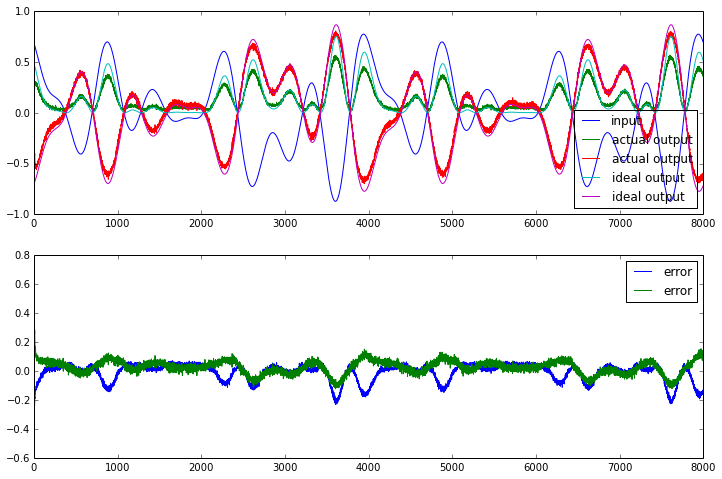

In [6]:
pylab.figure(figsize=(12,8))
pylab.subplot(2, 1, 1)
pylab.plot(test_t, test_signal, label='input')
pylab.plot(test_t, output, label='actual output')
pylab.plot(test_t, filter.filt(test_target, dt=1), label='ideal output', lw=1)
pylab.legend(loc='best')
pylab.subplot(2, 1, 2)
pylab.plot(test_t, error, label='error')
pylab.legend(loc='best')
pylab.show()


The network has successfully learned decoders for this function.  Note that the resulting error is a bit larger than in the offline learning case.  This is expected, and can be improved by tweaking the training process and we are also looking at ways of tweaking the error calculation in the model itself (likely by giving the decoders a few more bits and/or performing rounding differently).